### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import STOPWORDS
import string
%matplotlib inline

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


Similaridad de textos falsos entre  si y reales entre si

In [8]:
f = tweets.groupby("target").get_group(0)
f.info()
f.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4284 entries, 15 to 7593
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4284 non-null   int64 
 1   keyword   4265 non-null   object
 2   location  2854 non-null   object
 3   text      4284 non-null   object
 4   target    4284 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 200.8+ KB


,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [9]:
v = tweets.groupby("target").get_group(1)
v.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3150 non-null   int64 
 1   keyword   3113 non-null   object
 2   location  2128 non-null   object
 3   text      3150 non-null   object
 4   target    3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 147.7+ KB


In [10]:
import re
def preprocess(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

In [11]:
from datasketch import MinHash,MinHashLSH

def get_minhash(data):
    minhash = []
    for row in data.iterrows():
        text = row[1][3]
        id = row[1][0]
        tokens = preprocess(text)
        m = MinHash(num_perm=512)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append([id,m])
    return minhash

In [12]:
minhashs_f = get_minhash(f)
minhashs_v = get_minhash(v)

In [39]:
def calcular_cercania(minhashs):
    final = []
    for i in range(1,20):

        lsh = MinHashLSH(threshold=i/20, num_perm=512)
        for minhash in minhashs:
            lsh.insert(minhash[0],minhash[1])
        values = []
        
        for minhash in minhashs:
            values.append(len(lsh.query(minhash[1])))
        final.append(values)
    return final

In [14]:
cerca_segun_treshold_f = calcular_cercania(minhashs_f)
cerca_segun_treshold_v = calcular_cercania(minhashs_v)

In [40]:
real_avg = []
fake_avg = []
indx = list(range(5,100,5))

for i in range(0,19):
    real_avg.append(sum(cerca_segun_treshold_v[i])//len(cerca_segun_treshold_v[i]))

for i in range(0,19):
    fake_avg.append(sum(cerca_segun_treshold_f[i])//len(cerca_segun_treshold_f[i]))


In [41]:
print(real_avg)
print(fake_avg)

[641, 148, 60, 55, 33, 33, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
[929, 257, 102, 88, 53, 53, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [48]:
real = pd.DataFrame(real_avg,index = indx)
real.columns = ["AVG Match"]
fake = pd.DataFrame(fake_avg,index = indx)
fake.columns = ["AVG Match"]
real.head(20)

,AVG Match
5,641
10,148
15,60
20,55
25,33
30,33
35,3
40,3
45,3
50,2


TOP 50 DESASTRES COMENTADOS EN LOS TWEETS

In [17]:
desastres = tweets.groupby("keyword").agg({"target":["count","mean"]})
level0 = desastres.columns.get_level_values(0)
level1 = desastres.columns.get_level_values(1)
desastres.columns = level0 + "_" + level1
desastres.sort_values(by="target_count",ascending = False,inplace = True)
desastres = desastres.head(50) #TOP 50

[]

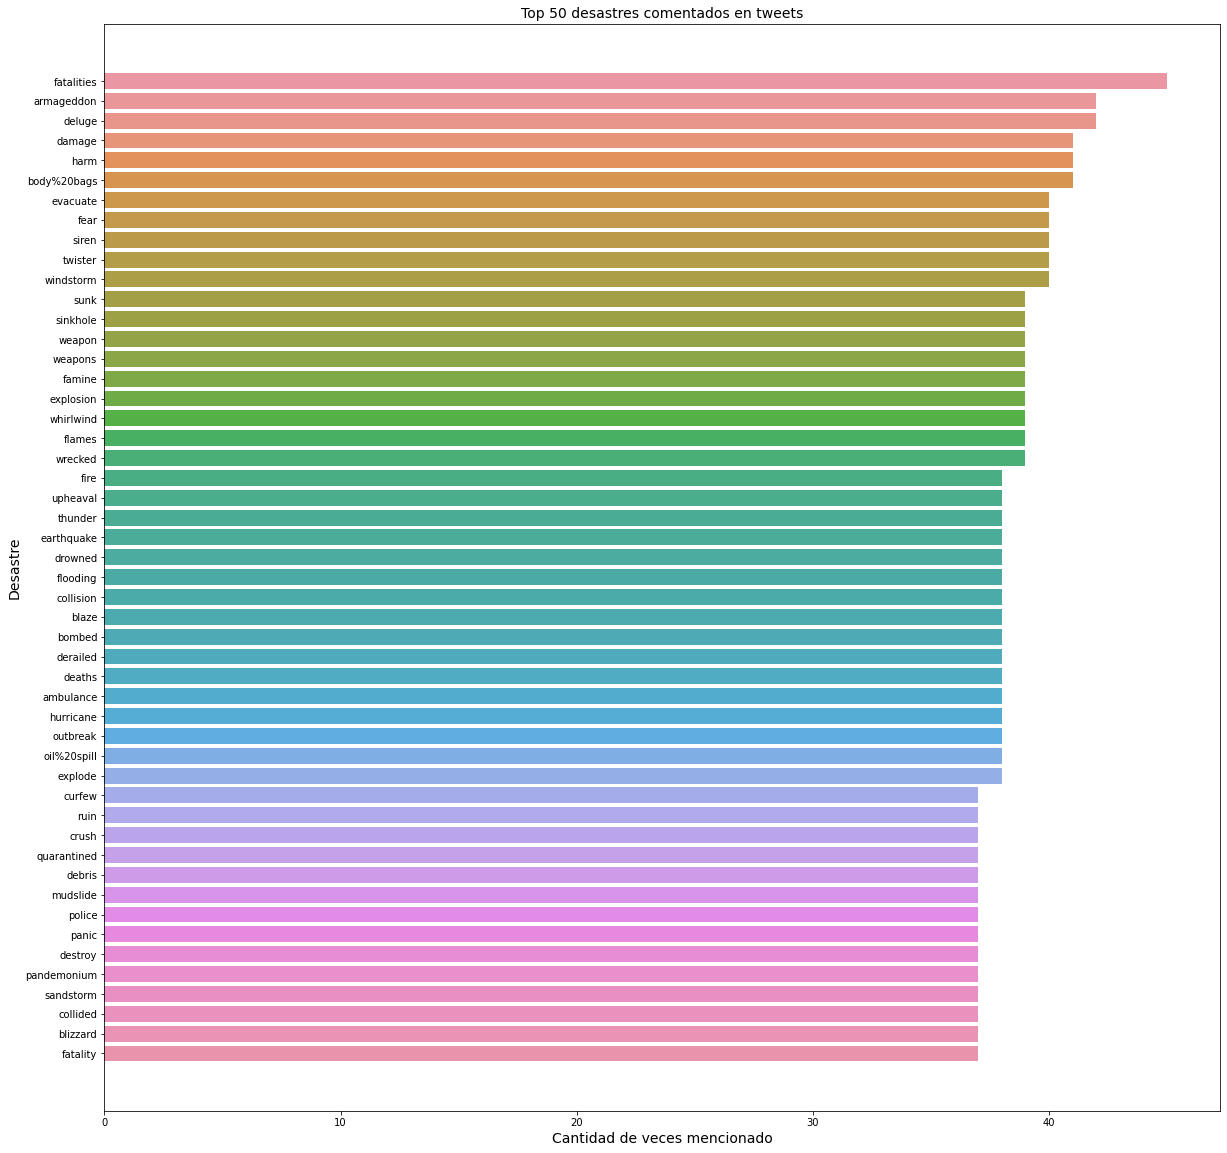

In [18]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = desastres,x = "target_count",y = desastres.index)
grafico.set_title("Top 50 desastres comentados en tweets",fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado",fontsize = 14)
grafico.set_ylabel("Desastre",fontsize = 14)
grafico.plot()

TOP PALABRAS EN LOS TWEETS

In [19]:
def by_word_count(dataframe):
    word_list = dataframe["text"].str.split()
    all_stopwords_gensim = STOPWORDS.union(set(string.punctuation))
    filtered = [word for word in np.concatenate(word_list.values) if not word in all_stopwords_gensim]
    words = pd.DataFrame(filtered,columns = ["word"])
    words["amount"] = 1
    by_count = words.groupby(["word"]).agg({"amount":["count"]})
    level0 = by_count.columns.get_level_values(0)
    level1 = by_count.columns.get_level_values(1)
    by_count.columns = level0 + "_" + level1
    by_count.sort_values(by="amount_count",ascending = False,inplace = True)
    return by_count.head(10)

In [20]:
true = tweets["target"] == 1
true = by_word_count(tweets[true])

false = tweets["target"] == 0
false = by_word_count(tweets[false])

[]

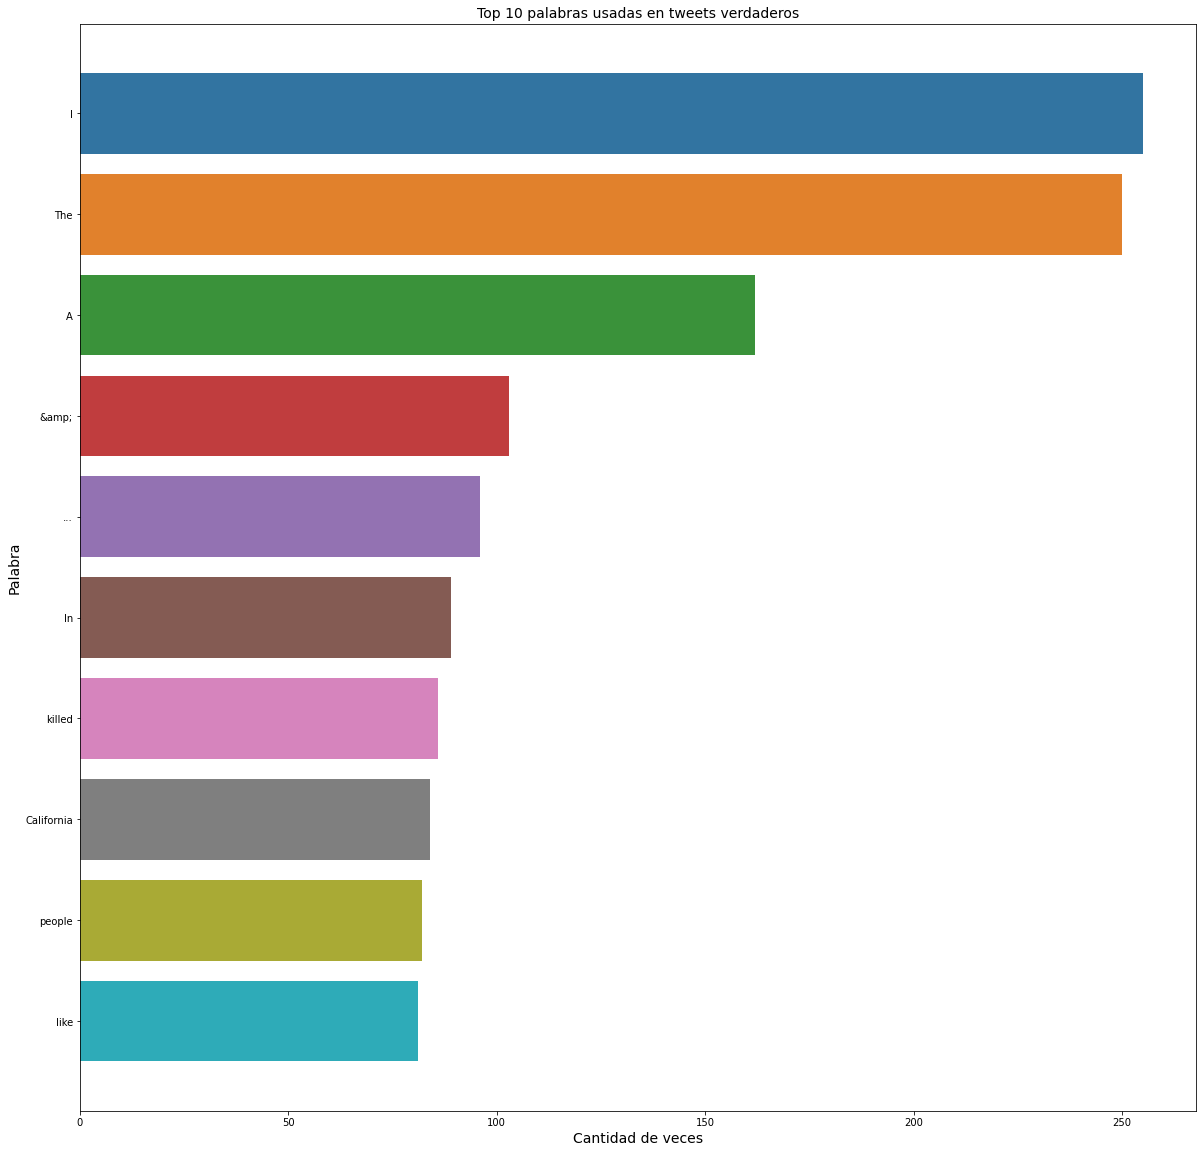

In [21]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = true,x = "amount_count",y=true.index)
grafico.set_title("Top 10 palabras usadas en tweets verdaderos",fontsize = 14)
grafico.set_xlabel("Cantidad de veces",fontsize = 14)
grafico.set_ylabel("Palabra",fontsize = 14)
grafico.plot()

[]

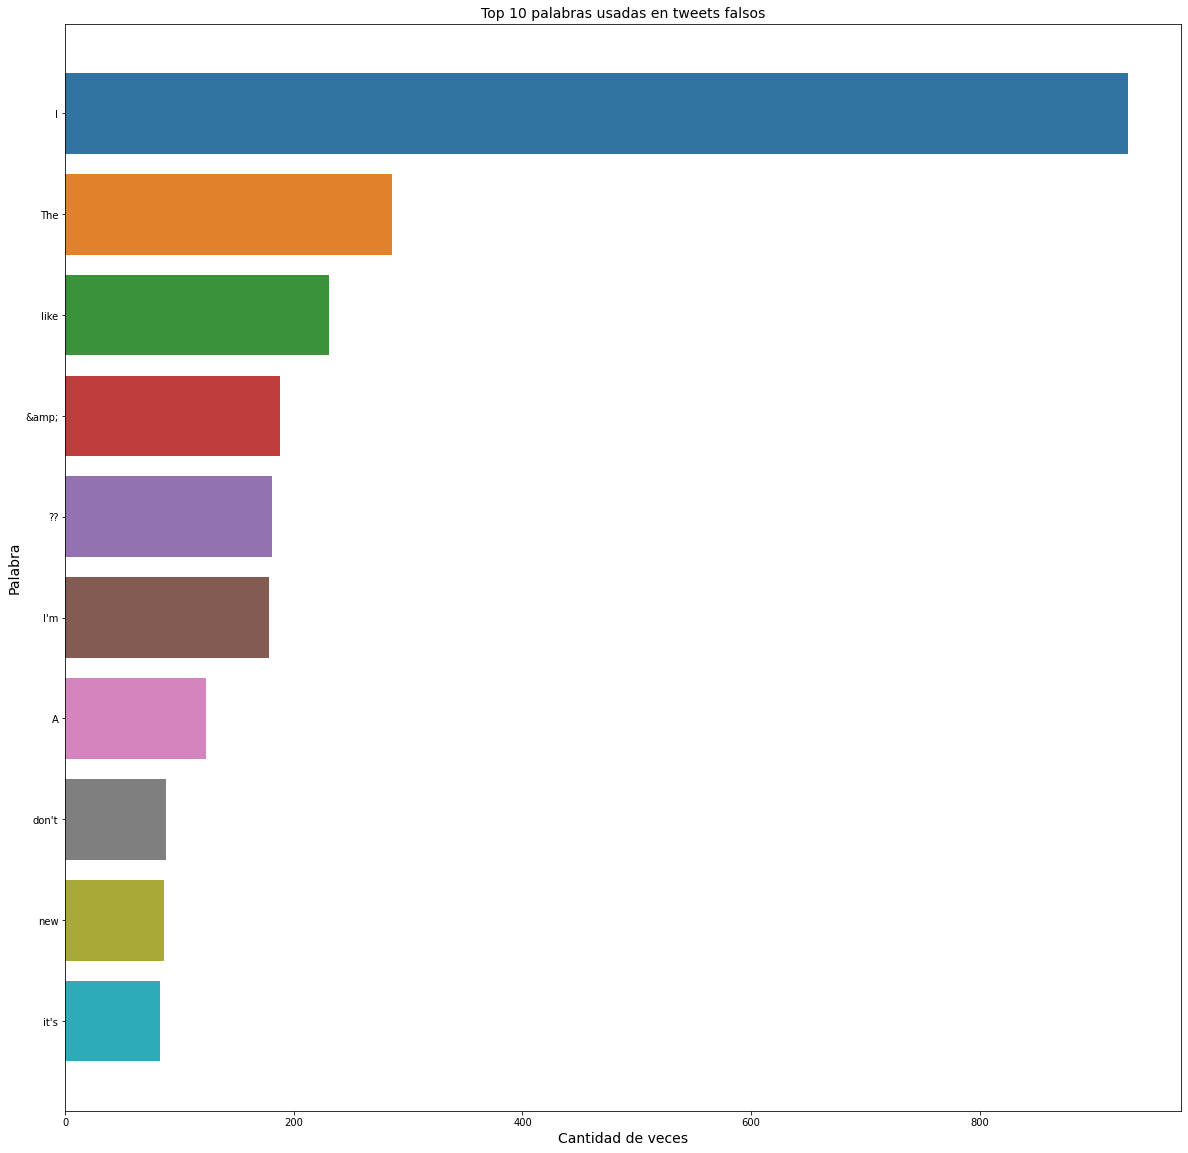

In [22]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = false,x = "amount_count",y=false.index)
grafico.set_title("Top 10 palabras usadas en tweets falsos",fontsize = 14)
grafico.set_xlabel("Cantidad de veces",fontsize = 14)
grafico.set_ylabel("Palabra",fontsize = 14)
grafico.plot()

CUALES SON LOS HASHTAG QUE MAS TIENEN LOS REALES/FAKE

In [23]:
tweets['hashtags'] = tweets['text'].str.findall(r'#.*?(?=\s|$)')
tweets_hashtags = tweets.explode('hashtags')

In [24]:
true = tweets_hashtags.groupby("target").get_group(1)
verdaderos = true.groupby('hashtags').agg({'target':'count'})
verdaderos.sort_values(by="target",ascending = False,inplace = True)
verdaderos = verdaderos.head(50)
verdaderos.head(3)

,target
hashtags,
#News,32
#???,23
#news,21


[]

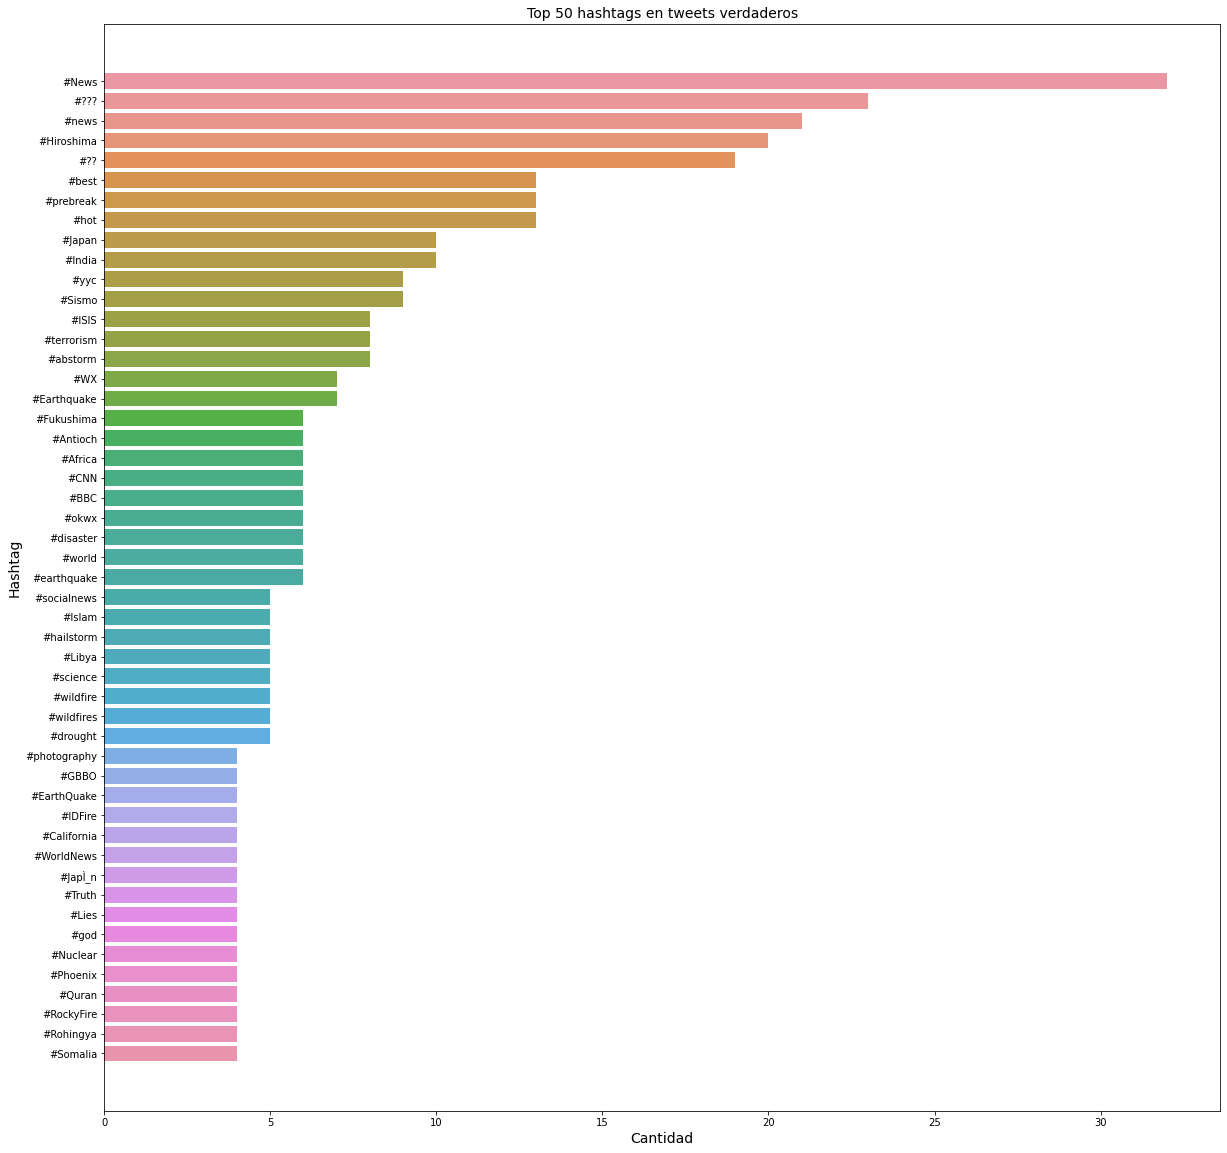

In [25]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = verdaderos,x = "target",y = verdaderos.index)
grafico.set_title("Top 50 hashtags en tweets verdaderos",fontsize = 14)
grafico.set_xlabel("Cantidad",fontsize = 14)
grafico.set_ylabel("Hashtag",fontsize = 14)
grafico.plot()

In [26]:
false = tweets_hashtags.groupby("target").get_group(0)
falsos = false.groupby('hashtags').agg({'target':'count'})
falsos.sort_values(by="target",ascending = False,inplace = True)
falsos = falsos.head(50)
falsos.head(5)

,target
hashtags,
#best,17
#hot,17
#prebreak,17
#news,15
#GBBO,13


[]

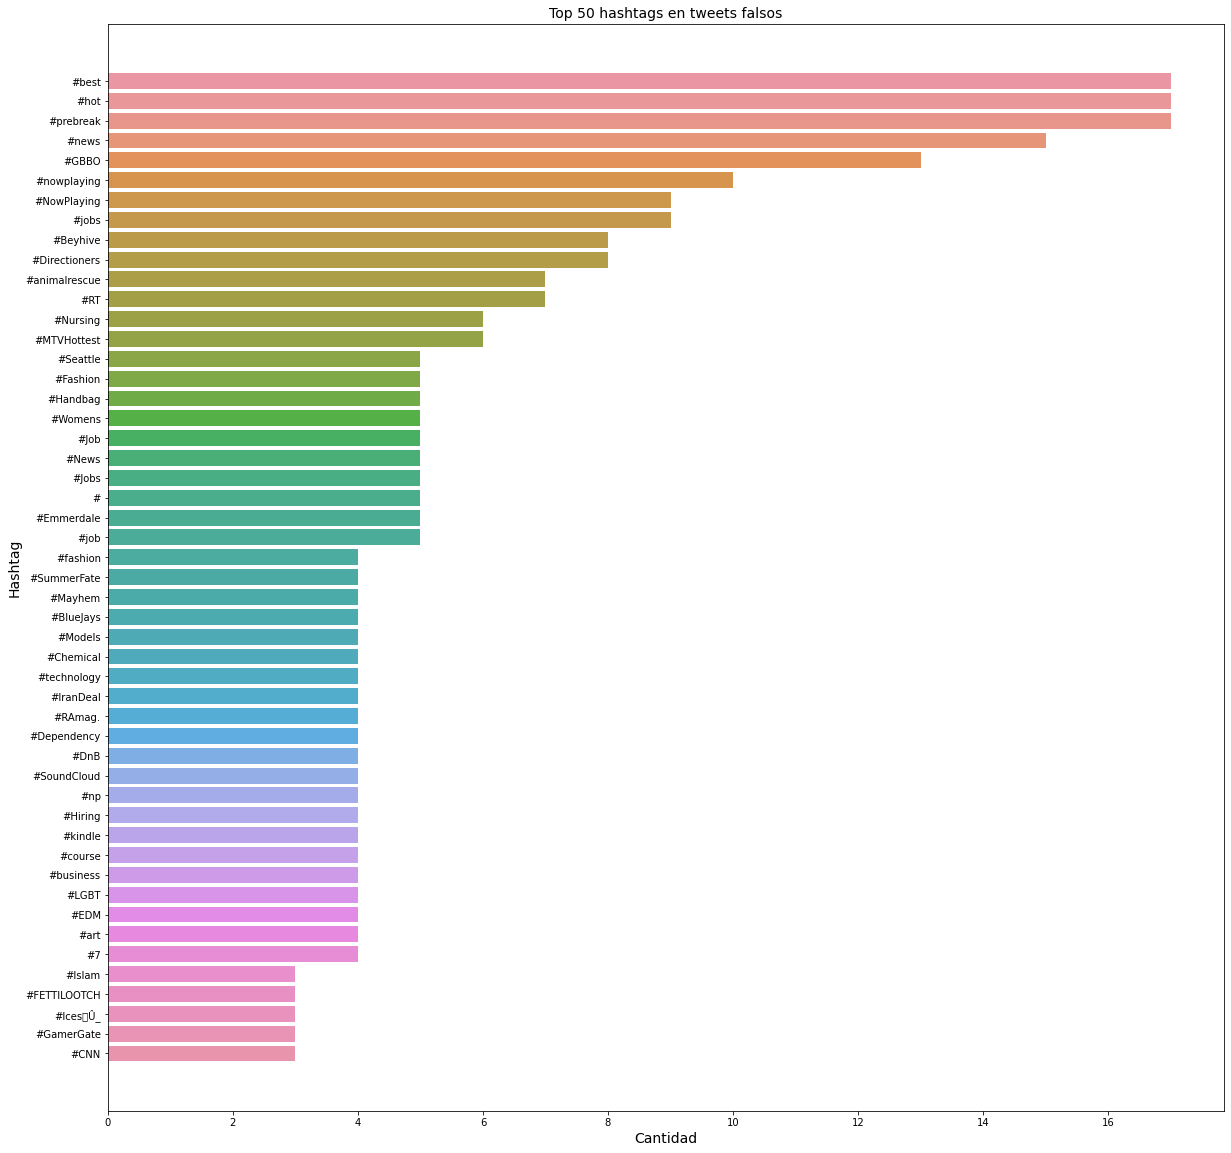

In [27]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = falsos,x = "target",y = falsos.index)
grafico.set_title("Top 50 hashtags en tweets falsos",fontsize = 14)
grafico.set_xlabel("Cantidad",fontsize = 14)
grafico.set_ylabel("Hashtag",fontsize = 14)
grafico.plot()